In [2]:
import sys

import meta_dataloader.TCGA

#import models.mlp, models.gcn
import numpy as np
import data.gene_graphs
import collections
import sklearn.metrics
import sklearn.model_selection
import random
from collections import OrderedDict
import pandas as pd
from torch.optim import Optimizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
%load_ext autoreload
%autoreload 2

In [3]:
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [4]:
tasks = meta_dataloader.TCGA.TCGAMeta(
                                      min_samples_per_class=10
                                     )
#task = tasks[113]

In [5]:
print(len(tasks.task_ids))

174


In [198]:
for taskid in sorted(tasks.task_ids):
    print(taskid)

('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUNG')
('GeneExp_Subtype', 'GBM')
('Metastasis_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('_EVENT', 'ACC')
('_EVENT', 'BLCA')
('_EVENT', 'BRCA')
('_EVENT', 'CESC')
('_EVENT', 'CHOL')
('_EVENT', 'COAD')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'GBM')
('_EVENT', 'GBMLGG')
('_EVENT', 'HNSC')
('_EVENT', 'KICH')
('_EVENT', 'KIRP')
('_EVENT', 'LAML')
('_EVENT', 'LGG')
('_EVENT', 'LIHC')
('_EVENT', 'LUAD')
('_EVENT', 'LUNG')
('_EVENT', 'LUSC')
('_EVENT', 'MESO')
('_EVENT', 'OV')
('_EVENT', 'PAAD')
('_EVENT', 'READ')
('_EVENT', 'SARC')
('_EVENT', 'SKCM')
('_EVENT', 'STAD')
('_EVENT', 'THCA')
('_EVENT', 'UCEC')
('_EVENT', 'UCS')
('_EVENT', 'UVM')
('_PANCAN_DNAMethyl_BLCA', 'BLCA')
('_PANCAN_DNAMethyl_BRCA', 'BRCA')
('_PANCAN_DNAMethyl_HNSC', 'HNSC')
('_PANCAN_DNAMethyl_LUAD', 'LUAD')
('_PANCAN_DNAMethyl_LUSC', 'LUSC')
('_PANCAN_mirna_BLCA', 'BLCA')
('_PANCAN_mirna_BRCA', 'BRCA')
('_PANCAN_mirn

In [6]:
task = meta_dataloader.TCGA.TCGATask(('histological_type', 'LGG'))
print(task.id)
print(task._samples.shape)
print(np.asarray(task._labels).shape)
print(collections.Counter(task._labels))

('histological_type', 'LGG')
(529, 20530)
(529,)
Counter({2: 198, 0: 197, 1: 134})


In [193]:
for task in sorted(tasks):
    print(task)
    if task.id == ('gender', 'COAD'):
        print(task.id)
        print(task._samples.shape)
        print(np.asarray(task._labels).shape)
        print(len(collections.Counter(task._labels)))

KeyboardInterrupt: 

In [347]:
def load_sets(task, valid=False):
     
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                task._labels, 
                                                                                stratify=task._labels,
                                                                                train_size=50,
                                                                                test_size=100,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                                 )
    
    train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
    test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

    if valid:
        X_test, X_valid, y_test, y_valid = sklearn.model_selection.train_test_split(X_test, 
                                                                                y_test, 
                                                                                stratify=y_test,
                                                                                train_size=50,
                                                                                test_size=50,
                                                                                shuffle=True,
                                                                                random_state=0
                                                                               )
        valid_set = TensorDataset( Tensor(X_valid), Tensor(y_valid))
        return train_set, valid_set, test_set
    
    return train_set, test_set 

In [5]:
from sklearn.dummy import DummyClassifier
def Majority(X_train, X_test, y_train, y_test, random_state):
    
    classifier = DummyClassifier(strategy='most_frequent', random_state=random_state)
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    accuracy = (predicted == y_test).mean()*100.
    return accuracy

In [170]:
class LogisticRegression(torch.nn.Module):
    
    def __init__(self, seed, input_size, num_classes, learning_rate, batch_size, epochs):
        super(LogisticRegression, self).__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.linear = torch.nn.Linear(input_size, num_classes)
        
        random.seed(seed)
        torch.manual_seed(seed)
    
    def forward(self, x, params=None):
        return self.linear(x)

    @property
    def criterion(self):
        return torch.nn.CrossEntropyLoss()
    
    @property
    def optimizer(self):
        return torch.optim.LBFGS(self.parameters(), lr=1)


In [316]:
def train(model, dataset, task_id, stop_early=False):
    train_loss = []
    criterion = model.criterion
    if type(model).__name__ == "LogisticRegression":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate, weight_decay= model.weight_decay)
     
    if stop_early:
        print("")
    else:
        train_set = dataset
        valid_set = None
 
    for i in range(model.epochs):
        for batch, labels in torch.utils.data.DataLoader(train_set, batch_size=model.batch_size, shuffle=True):
            labels = torch.autograd.Variable(labels.long())
            
            def closure():
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, labels)
                loss.backward()
                return loss
            
            intermediate = optimizer.step(closure)
            loss = intermediate.item()
            train_loss.append(loss)

    return model, loss

In [174]:
def test(model, test_set):
    # Test the Model
    batch, labels = next(iter(torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=False)))
    model.eval()
    outputs = model(batch)
    _, predicted = torch.max(outputs.data, 1)

    predicted = predicted.numpy()
    labels = labels.numpy()
    accuracy = (predicted == labels).mean()*100.
    return accuracy

# Logisitic Regression and Majority Experiments:

In [201]:
avg_maj_acc, avg_lr_acc = {}, {}
weight_decay = 0.05
batch_size = 32
epochs=100
for taskid in sorted(tasks.task_ids):
    task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    for seed in [0,1,2,3,4,5,6,7,8,9,10]:
        try:
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(task._samples, 
                                                                                        task._labels, 
                                                                                        stratify=task._labels,
                                                                                        train_size=50,
                                                                                        test_size=100,
                                                                                        shuffle=True,
                                                                                        random_state=0
                                                                                         )
            train_set = TensorDataset( Tensor(X_train), Tensor(y_train))
            test_set = TensorDataset( Tensor(X_test), Tensor(y_test))

            #-----Majority-----
            mj_acc = Majority(X_train, X_test, y_train, y_test, seed)
            print("{} Majority Accuracy is: {}" .format(task.id, mj_acc))
            if task.id in avg_maj_acc.keys():
                avg_maj_acc[task.id].append(mj_acc)
            else:
                avg_maj_acc[task.id] = [mj_acc]

            #-----Logidtic Regression-----
            lr = 1.
            LR_model = LogisticRegression(seed, input_size, num_classes,lr, batch_size, epochs)
            trained_model, train_loss = train(LR_model, train_set, task.id, False)
            lr_result = test(trained_model, test_set)
            print("{} LR Accuracy is: {}" .format(task.id, lr_result))
            if task.id in avg_lr_acc.keys():
                avg_lr_acc[task.id].append(lr_result)
            else:
                avg_lr_acc[task.id] = [lr_result]

        except:
            print("Not enough samples!")

('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 62.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 56.99999999999999
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 64.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 57.99999999999999
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 69.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 38.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 61.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Accuracy is: 67.0
('Expression_Subtype', 'LUAD') Majority Accuracy is: 38.0
('Expression_Subtype', 'LUAD') LR Ac

('_EVENT', 'BLCA') LR Accuracy is: 51.0
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') LR Accuracy is: 56.00000000000001
('_EVENT', 'BLCA') Majority Accuracy is: 55.00000000000001
('_EVENT', 'BLCA') LR Accuracy is: 57.99999999999999
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 77.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 77.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 81.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 61.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 77.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 72.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 80.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('_EVENT', 'BRCA') LR Accuracy is: 81.0
('_EVENT', 'BRCA') Majority Accuracy is: 83.0
('

('_EVENT', 'HNSC') LR Accuracy is: 51.0
('_EVENT', 'HNSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'HNSC') LR Accuracy is: 51.0
('_EVENT', 'HNSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'HNSC') LR Accuracy is: 59.0
('_EVENT', 'HNSC') Majority Accuracy is: 55.00000000000001
('_EVENT', 'HNSC') LR Accuracy is: 60.0
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 80.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 83.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 84.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 80.0
('_EVENT', 'KIRP') Majority Accuracy is: 84.0
('_EVENT', 'KIRP') LR Accuracy is: 86.0
('_EVENT', 'K

('_EVENT', 'OV') LR Accuracy is: 56.99999999999999
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 55.00000000000001
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 56.00000000000001
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 56.00000000000001
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 54.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 45.0
('_EVENT', 'OV') Majority Accuracy is: 60.0
('_EVENT', 'OV') LR Accuracy is: 55.00000000000001
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') LR Accuracy is: 56.00000000000001
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') LR Accuracy is: 49.0
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') LR Accuracy is: 57.99999999999999
('_EVENT', 'PAAD') Majority Accuracy is: 52.0
('_EVENT', 'PAAD') LR Accuracy is: 63.0
('_EVENT', 'PAAD') Majority Accurac

('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 47.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 44.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 42.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') Majority Accuracy is: 30.0
('_PANCAN_DNAMethyl_BRCA', 'BRCA') LR Accuracy is: 45.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 70.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 65.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 66.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 70.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') Majority Accuracy is: 41.0
('_PANCAN_DNAMethyl_HNSC', 'HNSC') LR Accuracy is: 61.0


('_PANCAN_mirna_LAML', 'LAML') LR Accuracy is: 66.0
('_PANCAN_mirna_LAML', 'LAML') Majority Accuracy is: 35.0
('_PANCAN_mirna_LAML', 'LAML') LR Accuracy is: 68.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 33.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 39.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 43.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 43.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 12.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 34.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_mirna_LUAD', 'LUAD') LR Accuracy is: 39.0
('_PANCAN_mirna_LUAD', 'LUAD') Majority Accuracy is: 31.0
('_PANCAN_

('alcohol_history_documented', 'ESCA') LR Accuracy is: 67.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 59.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 61.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 65.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 66.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 61.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 70.0
('alcohol_history_documented', 'ESCA') Majority Accuracy is: 73.0
('alcohol_history_documented', 'ESCA') LR Accuracy is: 62.0
('alcohol_history_documented', 'ESCA') Majority Accuracy i

('animal_insect_allergy_history', 'GBMLGG') LR Accuracy is: 88.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 86.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 85.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 86.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 94.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 87.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 93.0
('animal_insect_allergy_history', 'LGG') Majority Accuracy is: 95.0
('animal_insect_allergy_history', 'LGG') LR Accuracy is: 92.0
('animal_insect_allergy_h

('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 47.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00000000000001
('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 50.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00000000000001
('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 48.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00000000000001
('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 9.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00000000000001
('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 51.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00000000000001
('birth_control_pill_history_usage_category', 'CESC') LR Accuracy is: 48.0
('birth_control_pill_history_usage_category', 'CESC') Majority Accuracy is: 55.00

('family_history_of_cancer', 'GBMLGG') LR Accuracy is: 50.0
('family_history_of_cancer', 'GBMLGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'GBMLGG') LR Accuracy is: 49.0
('family_history_of_cancer', 'GBMLGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'GBMLGG') LR Accuracy is: 50.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 49.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 49.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 62.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 55.00000000000001
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_history_of_cancer', 'LGG') LR Accuracy is: 50.0
('family_history_of_cancer', 'LGG') Majority Accuracy is: 62.0
('family_his

('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
('gender', 'BRCA') Majority Accuracy is: 99.0
('gender', 'BRCA') LR Accuracy is: 99.0
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
('gender', 'COAD') Majority Accuracy is: 54.0
('gend

('gender', 'KIRP') LR Accuracy is: 87.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 95.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 77.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 88.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 78.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 90.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 70.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 91.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 82.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 67.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 69.0
('gender', 'LAML') Majority Accuracy is: 54.0
('gender', 'LAML') LR Accuracy is: 83.0
('gender', 'LG

('gender', 'PCPG') LR Accuracy is: 81.0
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 71.0
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 73.0
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 74.0
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 55.00000000000001
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 77.0
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 78.0
('gender', 'SARC') Majority Accuracy is: 55.00000000000001
('gender', 'SARC') LR Accuracy is: 76.0
('gender', 'SARC') Majority Accura

('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD') Majority Accuracy is: 97.0
('histological_type', 'PRAD') LR Accuracy is: 97.0
('histological_type', 'PRAD'

('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 60.0
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 50.0
('lymphovascular_invasion_present', 'BLCA') Majority Accuracy is: 55.00000000000001
('lymphovascular_invasion_present', 'BLCA') LR Accuracy is: 52.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 66.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 61.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 63.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invasion_present', 'HNSC') LR Accuracy is: 70.0
('lymphovascular_invasion_present', 'HNSC') Majority Accuracy is: 64.0
('lymphovascular_invas

('oct_embedded', 'BLCA') LR Accuracy is: 86.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 82.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 79.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 76.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 79.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 83.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 81.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 78.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 78.0
('oct_embedded', 'BLCA') Majority Accuracy is: 85.0
('oct_embedded', 'BLCA') LR Accuracy is: 78.0
('oct_embedded', 'BRCA') Majority Accuracy is: 62.0
('oct_embedded', 'BR

('oct_embedded', 'LGG') LR Accuracy is: 56.99999999999999
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 44.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 51.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 44.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 46.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 51.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 41.0
('oct_embedded', 'LGG') Majority Accuracy is: 60.0
('oct_embedded', 'LGG') LR Accuracy is: 46.0
('oct_embedded', 'LIHC') Majority Accuracy is: 65.0
('oct_embedded', 'LIHC') LR Accuracy is: 62.0
('oct_embedded', 'LIHC') Majority Accuracy is: 65.0
('oct_embedded', 'LIHC') LR Accuracy is: 56.00000000000001
('oct_embedded', 'LIHC') Majority Accuracy is: 65.0
('oct_emb

('oct_embedded', 'STAD') LR Accuracy is: 61.0
('oct_embedded', 'STAD') Majority Accuracy is: 60.0
('oct_embedded', 'STAD') LR Accuracy is: 53.0
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
Not enough samples!
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') LR Accuracy is: 64.0
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') LR Accuracy is: 67.0
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') LR Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') LR Accuracy is: 67.0
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('oct_embedded', 'THCA') LR Accuracy is: 67.0
('oct_embedded', 'THCA') Majority Accuracy is: 57.99999999999999
('o

('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 69.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 94.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 93.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 91.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 95.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 94.0
('tumor_tissue_site', 'GBMLGG') Majority Accuracy is: 76.0
('tumor_tissue_site', 'GBMLGG') LR Accuracy is: 93.0
('tumor_tissue_site', 'PCPG') Majority Accuracy is: 82.0
('tumor_tissue_site', 'PCPG') LR Accuracy is: 87.0
('tumor_tissue_site', 'PCPG') Majority Accuracy is: 82.0
('tumor_tissue_site', 'PCPG') LR Accuracy is: 82.0
('tumor_tissue_site', 'PCPG') Majority Accuracy is: 82.0
('

In [202]:
print(avg_maj_acc)

{('Expression_Subtype', 'LUAD'): [38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0], ('Expression_Subtype', 'LUNG'): [38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0], ('GeneExp_Subtype', 'GBM'): [33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0], ('PAM50Call_RNAseq', 'BRCA'): [45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0], ('_EVENT', 'BLCA'): [55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001, 55.00000000000001], ('_EVENT', 'BRCA'): [83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0, 83.0], ('_EVENT', 'CESC'): [75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0]

In [203]:
print(avg_lr_acc)

{('Expression_Subtype', 'LUAD'): [62.0, 56.99999999999999, 64.0, 57.99999999999999, 69.0, 38.0, 61.0, 67.0, 60.0, 70.0, 61.0], ('Expression_Subtype', 'LUNG'): [62.0, 56.99999999999999, 64.0, 57.99999999999999, 69.0, 38.0, 61.0, 67.0, 60.0, 70.0, 61.0], ('GeneExp_Subtype', 'GBM'): [68.0, 25.0, 69.0, 64.0, 65.0, 70.0, 66.0, 51.0, 72.0, 68.0, 68.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [34.0, 40.0, 42.0, 45.0, 32.0, 42.0, 50.0, 42.0, 42.0, 42.0, 39.0], ('PAM50Call_RNAseq', 'BRCA'): [79.0, 74.0, 77.0, 15.0, 77.0, 73.0, 70.0, 68.0, 69.0, 78.0, 79.0], ('_EVENT', 'BLCA'): [59.0, 54.0, 59.0, 56.00000000000001, 55.00000000000001, 54.0, 56.99999999999999, 51.0, 51.0, 56.00000000000001, 57.99999999999999], ('_EVENT', 'BRCA'): [77.0, 77.0, 81.0, 61.0, 77.0, 72.0, 80.0, 81.0, 81.0, 73.0, 70.0], ('_EVENT', 'CESC'): [75.0, 72.0, 71.0, 69.0, 60.0, 69.0, 75.0, 67.0, 68.0, 68.0, 61.0], ('_EVENT', 'COAD'): [71.

In [257]:
print(np.std(avg_lr_acc[('white_cell_count_result', 'KIRP')]))
print(np.std(avg_maj_acc[('white_cell_count_result', 'KIRP')]))

5.1666444503210265
0.0


In [252]:
def measure_mean_std(model_dict):
    mean_std_results = {}
    for task in model_dict.keys():
        mean = np.mean(model_dict[task])
        std =  np.std(model_dict[task])
        mean_std_results[task] = {'mean':mean,'std': std}
    return mean_std_results

In [260]:
Maj_dict = measure_mean_std(avg_maj_acc)

In [299]:
import os
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'
result_dataframe = pd.DataFrame.from_dict(Maj_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'Majority_result_10seeds.csv'))

In [302]:
print(Maj_dict)
print(len(Maj_dict))#121

{('Expression_Subtype', 'LUAD'): {'mean': 38.0, 'std': 0.0}, ('Expression_Subtype', 'LUNG'): {'mean': 38.0, 'std': 0.0}, ('GeneExp_Subtype', 'GBM'): {'mean': 33.0, 'std': 0.0}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 49.0, 'std': 0.0}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 45.0, 'std': 0.0}, ('_EVENT', 'BLCA'): {'mean': 55.00000000000001, 'std': 0.0}, ('_EVENT', 'BRCA'): {'mean': 83.0, 'std': 0.0}, ('_EVENT', 'CESC'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'COAD'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'COADREAD'): {'mean': 76.0, 'std': 0.0}, ('_EVENT', 'ESCA'): {'mean': 57.99999999999999, 'std': 0.0}, ('_EVENT', 'GBM'): {'mean': 77.0, 'std': 0.0}, ('_EVENT', 'GBMLGG'): {'mean': 62.0, 'std': 0.0}, ('_EVENT', 'HNSC'): {'mean': 55.00000000000001, 'std': 0.0}, ('_EVENT', 'KIRP'): {'mean': 84.0, 'std': 0.0}, ('_EVENT', 'LAML'): {'mean': 65.0, 'std': 0.0}, ('_EVENT', 'LGG'): {'mean': 75.0, 'std': 0.0}, ('_EVENT', 'LIHC'): {'mean

In [ ]:
print(np.unique(Maj_dict.keys()[1]))

In [263]:
LR_dict= measure_mean_std(avg_lr_acc)
print(LR_dict)

{('Expression_Subtype', 'LUAD'): {'mean': 60.63636363636363, 'std': 8.227147161271832}, ('Expression_Subtype', 'LUNG'): {'mean': 60.63636363636363, 'std': 8.227147161271832}, ('GeneExp_Subtype', 'GBM'): {'mean': 62.36363636363637, 'std': 12.928282788822674}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 40.90909090909091, 'std': 4.640817824763715}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 69.0, 'std': 17.49805183961398}, ('_EVENT', 'BLCA'): {'mean': 55.45454545454545, 'std': 2.675261630829483}, ('_EVENT', 'BRCA'): {'mean': 75.45454545454545, 'std': 5.852173432520393}, ('_EVENT', 'CESC'): {'mean': 68.63636363636364, 'std': 4.617609126981925}, ('_EVENT', 'COAD'): {'mean': 71.36363636363636, 'std': 2.568081253059188}, ('_EVENT', 'COADREAD'): {'mean': 65.36363636363636, 'std': 5.032128182944745}, ('_EVENT', 'ESCA'): {'mean': 54.54545454545455, 'std': 4.185768884807758}, ('_EVENT', 'GBM'): {'mean': 66.18181818181819, 'std': 3.785575057028

In [303]:
result_dataframe = pd.DataFrame.from_dict(LR_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'LogisticRegression_result_10seeds.csv'))

[38.0, 38.0, 33.0, 98.0, 49.0, 45.0, 55.00000000000001, 83.0, 75.0, 75.0, 76.0, 57.99999999999999, 77.0, 62.0, 55.00000000000001, 84.0, 65.0, 75.0, 61.0, 63.0, 59.0, 55.00000000000001, 60.0, 52.0, 63.0, 52.0, 61.0, 97.0, 81.0, 30.0, 41.0, 43.0, 38.0, 32.0, 38.0, 35.0, 31.0, 56.99999999999999, 28.000000000000004, 60.0, 52.0, 73.0, 67.0, 61.0, 73.0, 77.0, 95.0, 95.0, 79.0, 94.0, 94.0, 91.0, 87.0, 55.00000000000001, 75.0, 66.0, 66.0, 71.0, 62.0, 62.0, 96.0, 96.0, 95.0, 73.0, 99.0, 54.0, 54.0, 84.0, 65.0, 56.99999999999999, 73.0, 73.0, 54.0, 55.00000000000001, 66.0, 54.0, 60.0, 74.0, 55.00000000000001, 55.00000000000001, 55.00000000000001, 62.0, 65.0, 73.0, 49.0, 38.0, 82.0, 97.0, 62.0, 69.0, 69.0, 55.00000000000001, 64.0, 69.0, 75.0, 75.0, 67.0, 85.0, 62.0, 55.00000000000001, 57.99999999999999, 63.0, 51.0, 59.0, 60.0, 65.0, 69.0, 89.0, 85.0, 80.0, 60.0, 57.99999999999999, 65.0, 95.0, 96.0, 76.0, 76.0, 82.0, 77.0, 77.0, 74.0]


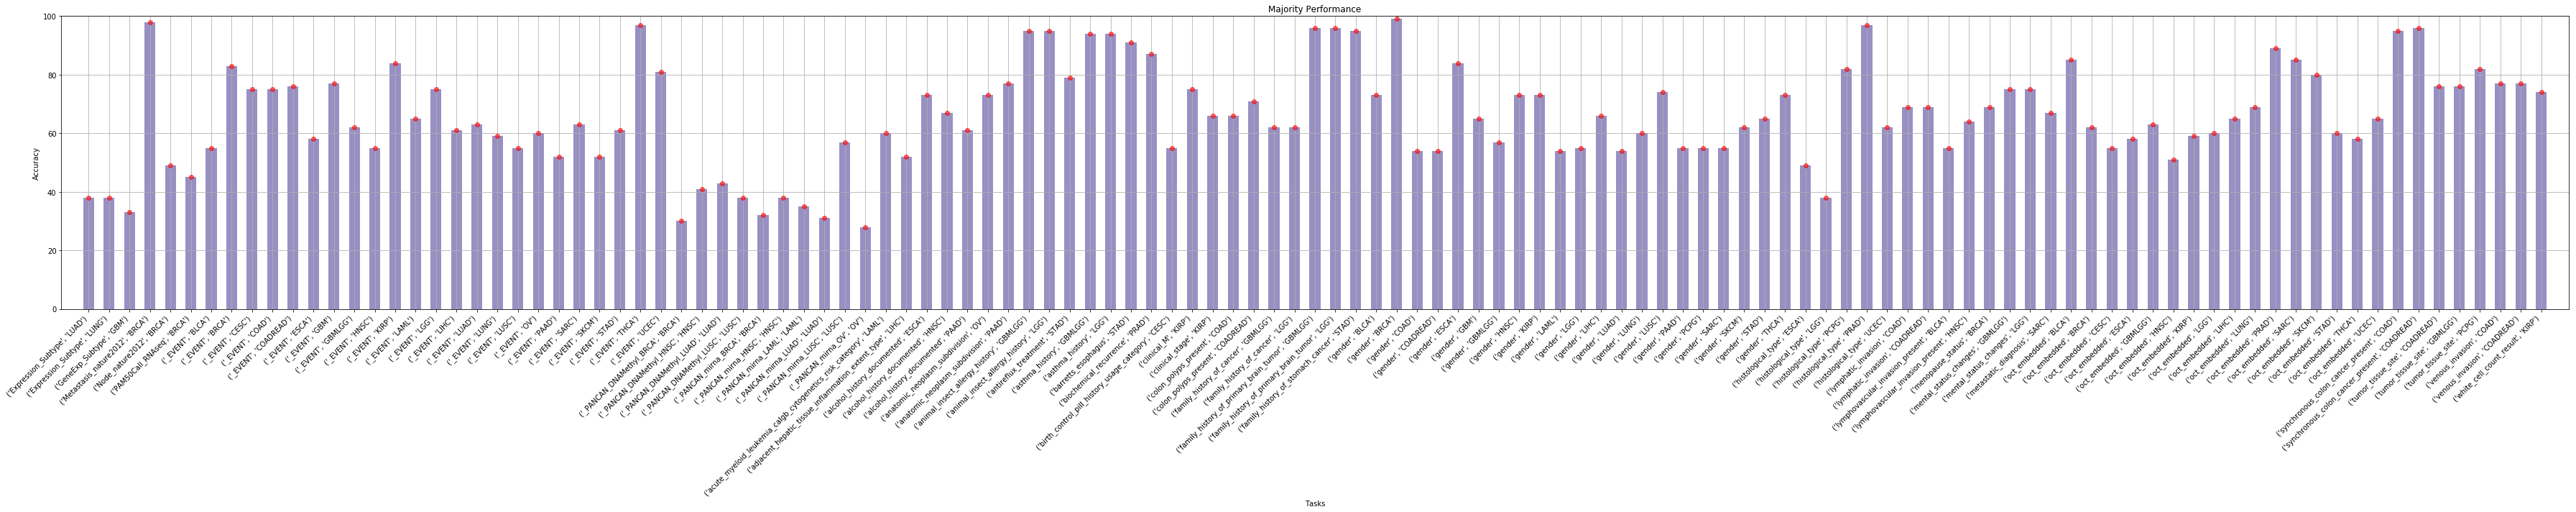

In [296]:
model_visualization(Maj_dict, list(Maj_dict.keys()), "Majority", color='#332288')

[60.63636363636363, 60.63636363636363, 62.36363636363637, 98.0, 40.90909090909091, 69.0, 55.45454545454545, 75.45454545454545, 68.63636363636364, 71.36363636363636, 65.36363636363636, 54.54545454545455, 66.18181818181819, 73.18181818181819, 57.09090909090909, 84.27272727272727, 52.72727272727273, 70.81818181818181, 57.81818181818182, 55.54545454545455, 58.18181818181818, 55.72727272727273, 54.45454545454545, 56.0, 54.81818181818182, 59.18181818181818, 56.90909090909091, 95.9090909090909, 78.54545454545455, 47.63636363636363, 62.36363636363637, 46.27272727272727, 52.63636363636363, 23.727272727272727, 51.90909090909091, 59.18181818181818, 33.81818181818182, 48.72727272727273, 26.818181818181817, 68.27272727272727, 52.54545454545455, 62.27272727272727, 65.36363636363636, 51.54545454545455, 64.18181818181819, 71.45454545454545, 89.9090909090909, 89.9090909090909, 75.63636363636364, 92.9090909090909, 92.9090909090909, 88.27272727272727, 81.81818181818181, 45.54545454545455, 68.818181818181

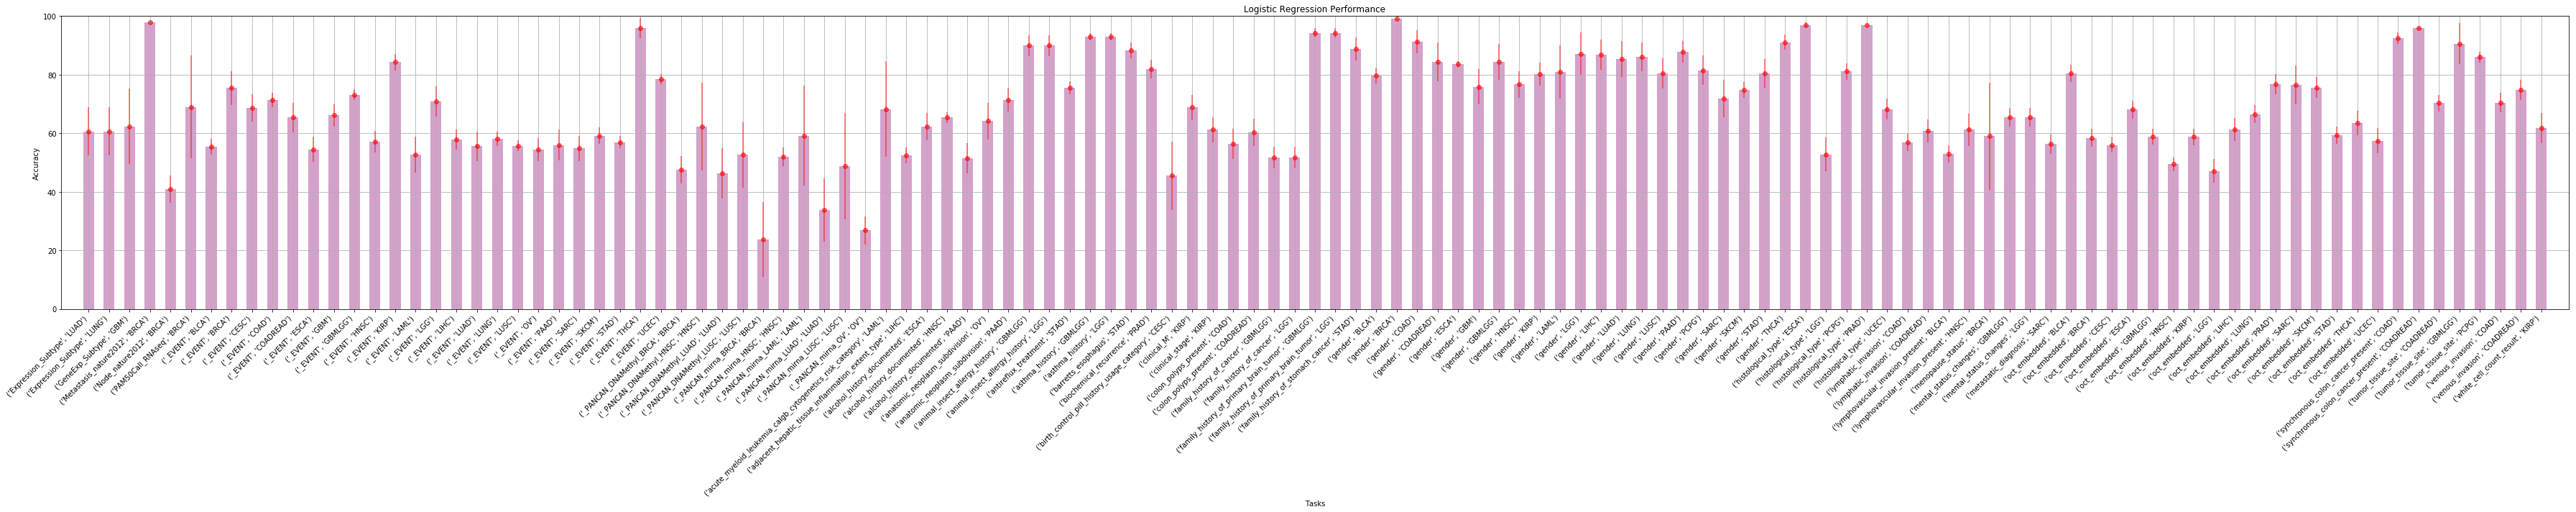

In [295]:
model_visualization(LR_dict, list(LR_dict.keys()), "Logistic Regression", '#AA4499')

In [363]:
import matplotlib.pyplot as plt
def model_visualization(model_dict, tasks, label="model_name", color='#332288'):
    means, stds = [], []
    for task in tasks:
        means.append(model_dict[task]['mean'])   
        stds.append(model_dict[task]['std'])
    print(means)
    width = 0.5 # the width of the bars
    colors = ['#332288', '#AA4499', '#44AA99']
    #flatten_std = [item for sublist in stds for item in sublist]
    x = np.arange(len(tasks))
    new_x = [1.5*i for i in x]
    fig, ax = plt.subplots(figsize=(50, 10))
    plt.bar(new_x, means, color=color, alpha=0.5)
    plt.xticks(new_x, tasks)
    plt.title("{} Performance".format(label))
    plt.ylabel('Accuracy')
    plt.xlabel('Tasks')
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    plt.xlim(min(new_x) - 2, max(new_x) + 2)
    plt.ylim(0, 100)
    plt.grid()
    plt.errorbar(new_x, means, stds, linestyle='None', marker='o', color='r', alpha=0.6)
    fig.tight_layout()
    plt.show()

    #plt.savefig('/{}_result_plot_with_error_bars.png'.format(label))


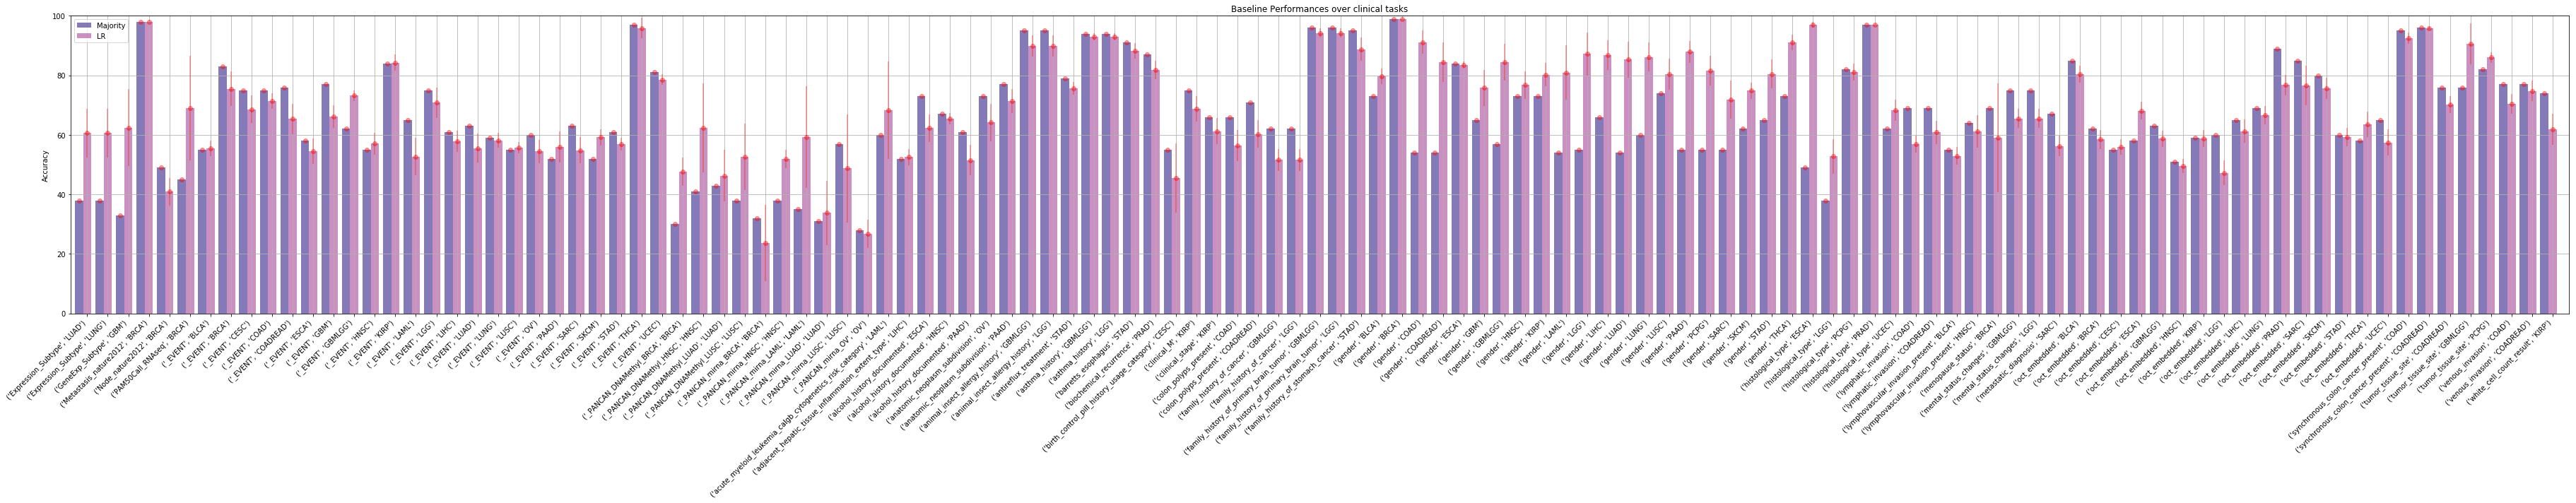

In [328]:
all_visualization(Maj_dict,LR_dict)

In [378]:
def all_visualization(Ma_dic, LR_dic, MLP_dic):
    
    Mlp_means, Mlp_std = [], []
    LR_means, LR_std = [], []
    Maj_means, Maj_std = [], []
    tasks = LR_dic.keys()
    for task in tasks:
        Maj_means.append(Ma_dic[task]['mean'])
        Maj_std.append(Ma_dic[task]['std'])
        LR_means.append(LR_dic[task]['mean'])
        LR_std.append(LR_dic[task]['std'])
        Mlp_means.append(MLP_dic[task]['mean'])
        Mlp_std.append(MLP_dic[task]['std'])
    
    x = np.arange(len(tasks))
    new_x = [1.5*i for i in x]
    fig, ax = plt.subplots(figsize=(50, 10))
    width = 0.4
    colors = ['#332288', '#AA4499', '#44AA99']
    ax.bar([p - width for p in new_x],
            Maj_means,
            width,
            alpha=0.6,
            color='#332288',
            label='Majority')
    ax.bar(new_x,
            LR_means,
            width,
            alpha=0.6,
            color='#AA4499',
            label='LR')
    ax.bar([p + width for p in new_x],
            Mlp_means,
            width,
            alpha=0.6,
            color='#44AA99',
            label='MLP')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Baseline Performances over clinical tasks')
    ax.set_xticks([p  for p in new_x])
    ax.set_xticklabels(tasks, rotation=45, ha="right")
    fig.tight_layout()

    plt.legend(['Majority', 'LR', 'MLP'], loc='upper left')
    plt.grid()
    
    # Error bars
    x_e, y_e, e = [], [], []
    for i in new_x:
        x_e.append([i-width, i, i+width])

    for i, task in enumerate(tasks):
        y_e.append([Maj_means[i], LR_means[i], Mlp_means[i]])

    for i, task in enumerate(tasks):
        e.append([Maj_std[i], LR_std[i], Mlp_std[i]])

    flatten_x = [item for sublist in x_e for item in sublist]
    flatten_y = [item for sublist in y_e for item in sublist]
    flatten_e = [item for sublist in e for item in sublist]


    plt.xlim(min(x) - 2 * width, max(x) + width * 2)
    plt.ylim(0, 100)

    plt.errorbar(flatten_x, flatten_y, flatten_e, linestyle='None', marker='o', color='r', alpha=0.4)
    plt.savefig(path + '/new_result_plot_with_error_bars.png')
    plt.show()

In [305]:
collections.Counter(y_train)

Counter({1: 17, 2: 6, 3: 3, 0: 24})

# MLP

In [346]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, seed, input_size, num_classes, num_layers, channels, learning_rate, batch_size, epochs, patience, weight_decay):
        super(MultiLayerPerceptron, self).__init__()
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.weight_decay = weight_decay
        self.num_layers = num_layers
        self.channels = channels
        self.output_size = num_classes
        random.seed(seed)
        torch.manual_seed(seed)
        
        nodes = []
        nodes += channels
        architecture = OrderedDict()
        for i in range(self.num_layers):
            architecture['fc' + str(i)] = nn.Linear(input_size, nodes[i])
            architecture['relu' + str(i)] = torch.nn.ReLU()
            input_size = nodes[i]

        self.features = nn.Sequential(architecture)

        self.classifier = nn.Linear(input_size, num_classes)
    
    @property
    def criterion(self):
        criterion = F.cross_entropy
        return criterion
    
    @property
    def optimizer(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

    def forward(self, x):
        x = x.view(-1, self.input_size)
        features = self.features(x)
        logits = self.classifier(features)
        return logits

In [339]:
for taskid in sorted(tasks.task_ids):
    print(taskid)
    task = meta_dataloader.TCGA.TCGATask(taskid)
    print(task.id)

('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUAD')
('Expression_Subtype', 'LUNG')
('Expression_Subtype', 'LUNG')
('GeneExp_Subtype', 'GBM')
('GeneExp_Subtype', 'GBM')
('Metastasis_nature2012', 'BRCA')
('Metastasis_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('Node_nature2012', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('PAM50Call_RNAseq', 'BRCA')
('_EVENT', 'ACC')
('_EVENT', 'ACC')
('_EVENT', 'BLCA')
('_EVENT', 'BLCA')
('_EVENT', 'BRCA')
('_EVENT', 'BRCA')
('_EVENT', 'CESC')
('_EVENT', 'CESC')
('_EVENT', 'CHOL')
('_EVENT', 'CHOL')
('_EVENT', 'COAD')
('_EVENT', 'COAD')
('_EVENT', 'COADREAD')
('_EVENT', 'COADREAD')
('_EVENT', 'ESCA')
('_EVENT', 'ESCA')
('_EVENT', 'GBM')
('_EVENT', 'GBM')
('_EVENT', 'GBMLGG')
('_EVENT', 'GBMLGG')
('_EVENT', 'HNSC')
('_EVENT', 'HNSC')
('_EVENT', 'KICH')
('_EVENT', 'KICH')
('_EVENT', 'KIRP')
('_EVENT', 'KIRP')
('_EVENT', 'LAML')
('_EVENT', 'LAML')
('_EVENT', 'LGG')


KeyboardInterrupt: 

In [353]:
#After hyperparameter search (in another notebook)
epochs = 250
patience = 10
batch_size = 32
lr= 0.0001 # best_lr
num_layer = 2 # best num_layer
channels = [128,64] # best channels
weight_decay = 0.0

In [357]:
avg_mlp_acc = {}

for taskid in sorted(tasks.task_ids):
    task = meta_dataloader.TCGA.TCGATask(taskid)
    input_size = task._samples.shape[1]
    num_classes = len(collections.Counter(task._labels))
    try:
        train_set, test_set = load_sets(task, valid = False)
        for seed in range(0,10):
            MLP_model = MultiLayerPerceptron(seed, input_size, num_classes, num_layer, channels, lr, batch_size, epochs, patience, weight_decay)
            trained_model, train_loss = train(MLP_model, train_set, taskid, False)
            mlp_result = test(trained_model, test_set)
            print("\n {} MLP Accuracy is: {}" .format(taskid, mlp_result))
            if task.id in avg_mlp_acc.keys():
                avg_mlp_acc[task.id].append(mlp_result)
            else:
                avg_mlp_acc[task.id] = [mlp_result]
    except:
        print("Not enough number of samples")


 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 68.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 71.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 70.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUAD') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 68.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 71.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 66.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 67.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 70.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 69.0

 ('Expression_Subtype', 'LUNG') MLP Accuracy is: 69.0

 ('Expres


 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 75.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LGG') MLP Accuracy is: 76.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 65.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 62.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 63.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 62.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 61.0

 ('_EVENT', 'LIHC') MLP Accuracy is: 59.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 52.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 59.0

 ('_EVENT', 'LUAD') MLP Accuracy is: 56.99999999999999

 ('_EVE


 ('_PANCAN_DNAMethyl_LUSC', 'LUSC') MLP Accuracy is: 61.0
Not enough number of samples

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 38.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 39.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 38.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 39.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 42.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 42.0

 ('_PANCAN_mirna_BRCA', 'BRCA') MLP Accuracy is: 43.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 52.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 54.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 55.00000000000001

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 54.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 52.0

 ('_PANCAN_mirna_HNSC', 'HNSC') MLP Accuracy is: 53.0

 ('_PANCAN_mirna_H


 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 77.0

 ('anatomic_neoplasm_subdivision', 'PAAD') MLP Accuracy is: 75.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy is: 95.0

 ('animal_insect_allergy_history', 'GBMLGG') MLP Accuracy i


 ('family_history_of_cancer', 'GBMLGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'GBMLGG') MLP Accuracy is: 50.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 48.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 50.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 55.00000000000001

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 51.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 52.0

 ('family_history_of_cancer', 'LGG') MLP Accuracy is: 50.0
Not enough number of samples

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('family_history_of_primary_brain_tumor', 'GBMLGG') MLP Accuracy is: 96.0

 ('


 ('gender', 'LIHC') MLP Accuracy is: 80.0

 ('gender', 'LIHC') MLP Accuracy is: 81.0

 ('gender', 'LIHC') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 83.0

 ('gender', 'LUAD') MLP Accuracy is: 85.0

 ('gender', 'LUAD') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 84.0

 ('gender', 'LUAD') MLP Accuracy is: 86.0

 ('gender', 'LUAD') MLP Accuracy is: 86.0

 ('gender', 'LUAD') MLP Accuracy is: 82.0

 ('gender', 'LUAD') MLP Accuracy is: 89.0

 ('gender', 'LUAD') MLP Accuracy is: 84.0

 ('gender', 'LUAD') MLP Accuracy is: 85.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 84.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 80.0

 ('gender', 'LUNG') MLP Accuracy is: 85.0

 ('gender', 'LUNG') MLP Accuracy is: 81.0

 ('gender', 'LUNG') MLP Accuracy is: 82.0

 ('gender', 'LUNG') MLP Accuracy is: 81.0

 ('gender', 'LUNG') MLP Accuracy is: 83.0

 ('gender', 'LUNG') MLP Accuracy is: 80.0

 ('gender'

Not enough number of samples
Not enough number of samples

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 54.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 53.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 52.0

 ('lymphovascular_invasion_present', 'BLCA') MLP Accuracy is: 54.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 60.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 64.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy is: 61.0

 ('lymphovascular_invasion_present', 'HNSC') MLP Accuracy


 ('oct_embedded', 'LIHC') MLP Accuracy is: 68.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 67.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 67.0

 ('oct_embedded', 'LIHC') MLP Accuracy is: 66.0
Not enough number of samples

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 68.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 66.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 70.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 69.0

 ('oct_embedded', 'LUNG') MLP Accuracy is: 68.0
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples

 ('oct_embedded', 'PR


 ('venous_invasion', 'COADREAD') MLP Accuracy is: 77.0
Not enough number of samples
Not enough number of samples
Not enough number of samples
Not enough number of samples

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 72.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 73.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 73.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0

 ('white_cell_count_result', 'KIRP') MLP Accuracy is: 74.0


In [358]:
print(avg_mlp_acc)

{('Expression_Subtype', 'LUAD'): [67.0, 68.0, 71.0, 66.0, 67.0, 70.0, 69.0, 69.0, 66.0, 69.0], ('Expression_Subtype', 'LUNG'): [67.0, 68.0, 71.0, 66.0, 67.0, 70.0, 69.0, 69.0, 66.0, 69.0], ('GeneExp_Subtype', 'GBM'): [75.0, 71.0, 71.0, 74.0, 74.0, 72.0, 73.0, 74.0, 75.0, 74.0], ('Metastasis_nature2012', 'BRCA'): [98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0], ('Node_nature2012', 'BRCA'): [45.0, 47.0, 47.0, 52.0, 45.0, 48.0, 47.0, 49.0, 44.0, 51.0], ('PAM50Call_RNAseq', 'BRCA'): [82.0, 80.0, 83.0, 77.0, 83.0, 78.0, 82.0, 80.0, 83.0, 82.0], ('_EVENT', 'BLCA'): [56.00000000000001, 60.0, 56.99999999999999, 60.0, 60.0, 59.0, 57.99999999999999, 61.0, 57.99999999999999, 56.99999999999999], ('_EVENT', 'BRCA'): [82.0, 82.0, 82.0, 82.0, 84.0, 82.0, 84.0, 84.0, 84.0, 83.0], ('_EVENT', 'CESC'): [70.0, 66.0, 68.0, 68.0, 69.0, 69.0, 68.0, 70.0, 69.0, 69.0], ('_EVENT', 'COAD'): [75.0, 76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 74.0, 76.0, 76.0], ('_EVENT', 'COADREAD'): [72.0, 73.0, 73.0, 74.0,

In [359]:
MLP_dict = measure_mean_std(avg_mlp_acc)

In [360]:
import os
path = '/Users/mandanasamiei/PycharmProjects/TCGA_Benchmark'
result_dataframe = pd.DataFrame.from_dict(Maj_dict, orient='index')
result_dataframe.to_csv(os.path.join(path,'MLP_result_10seeds.csv'))

In [361]:
print(MLP_dict)
print(len(MLP_dict))#121

{('Expression_Subtype', 'LUAD'): {'mean': 68.2, 'std': 1.5999999999999999}, ('Expression_Subtype', 'LUNG'): {'mean': 68.2, 'std': 1.5999999999999999}, ('GeneExp_Subtype', 'GBM'): {'mean': 73.3, 'std': 1.4177446878757824}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 47.5, 'std': 2.4596747752497685}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 81.0, 'std': 2.04939015319192}, ('_EVENT', 'BLCA'): {'mean': 58.6, 'std': 1.5620499351813317}, ('_EVENT', 'BRCA'): {'mean': 82.9, 'std': 0.9433981132056604}, ('_EVENT', 'CESC'): {'mean': 68.6, 'std': 1.1135528725660042}, ('_EVENT', 'COAD'): {'mean': 75.7, 'std': 0.6403124237432849}, ('_EVENT', 'COADREAD'): {'mean': 72.4, 'std': 0.9165151389911681}, ('_EVENT', 'ESCA'): {'mean': 52.4, 'std': 0.9165151389911679}, ('_EVENT', 'GBM'): {'mean': 73.9, 'std': 0.7000000000000001}, ('_EVENT', 'GBMLGG'): {'mean': 74.1, 'std': 0.30000000000000004}, ('_EVENT', 'HNSC'): {'mean': 60.1, 'std': 1.3000000000000012},

[68.2, 68.2, 73.3, 98.0, 47.5, 81.0, 58.6, 82.9, 68.6, 75.7, 72.4, 52.4, 73.9, 74.1, 60.1, 85.9, 60.2, 75.9, 62.4, 57.5, 62.0, 58.1, 58.2, 58.0, 56.5, 61.4, 57.9, 97.0, 79.9, 52.3, 75.0, 52.4, 61.0, 41.0, 53.6, 72.6, 39.9, 61.5, 30.9, 79.3, 56.3, 68.4, 65.1, 55.6, 73.0, 76.7, 95.0, 95.0, 76.5, 94.0, 94.0, 91.0, 86.6, 56.7, 72.5, 64.8, 60.6, 69.1, 51.2, 51.2, 96.0, 96.0, 94.0, 77.9, 99.0, 86.8, 78.6, 84.0, 70.8, 79.7, 75.8, 80.7, 54.2, 73.5, 81.3, 84.6, 82.0, 75.1, 82.1, 74.4, 71.5, 68.3, 77.6, 82.3, 97.6, 54.2, 84.0, 97.0, 71.4, 61.8, 66.2, 52.7, 61.9, 69.0, 68.1, 68.1, 58.7, 84.0, 56.5, 53.2, 70.0, 61.6, 44.6, 56.5, 45.1, 66.6, 68.6, 79.7, 80.5, 79.4, 66.5, 66.4, 58.9, 95.0, 96.0, 75.8, 96.0, 89.7, 77.0, 77.4, 73.6]


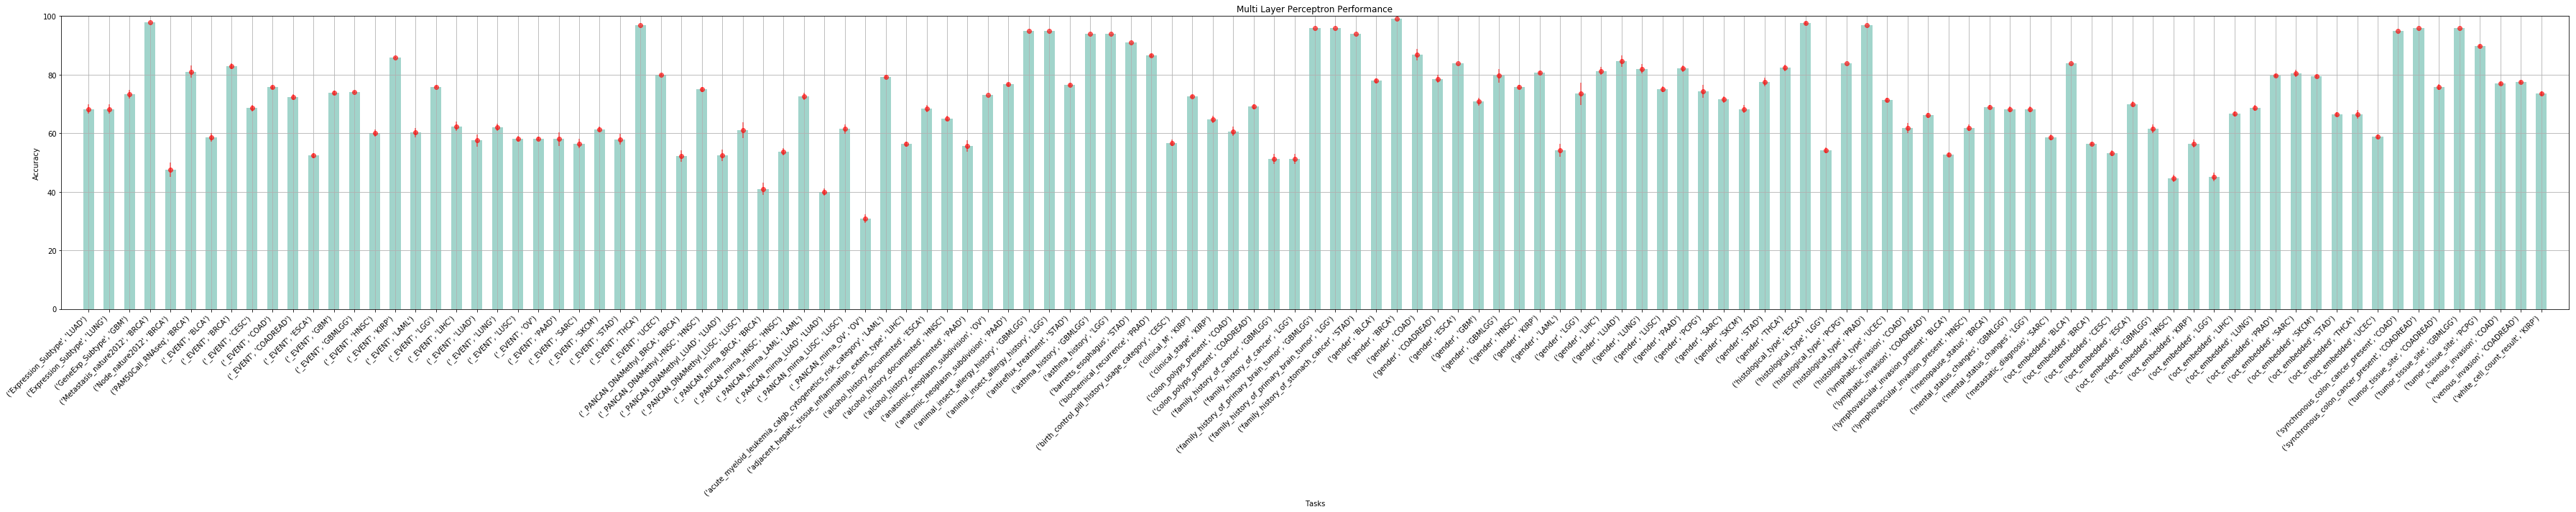

In [364]:
model_visualization(MLP_dict, list(MLP_dict.keys()), "Multi Layer Perceptron", '#44AA99')

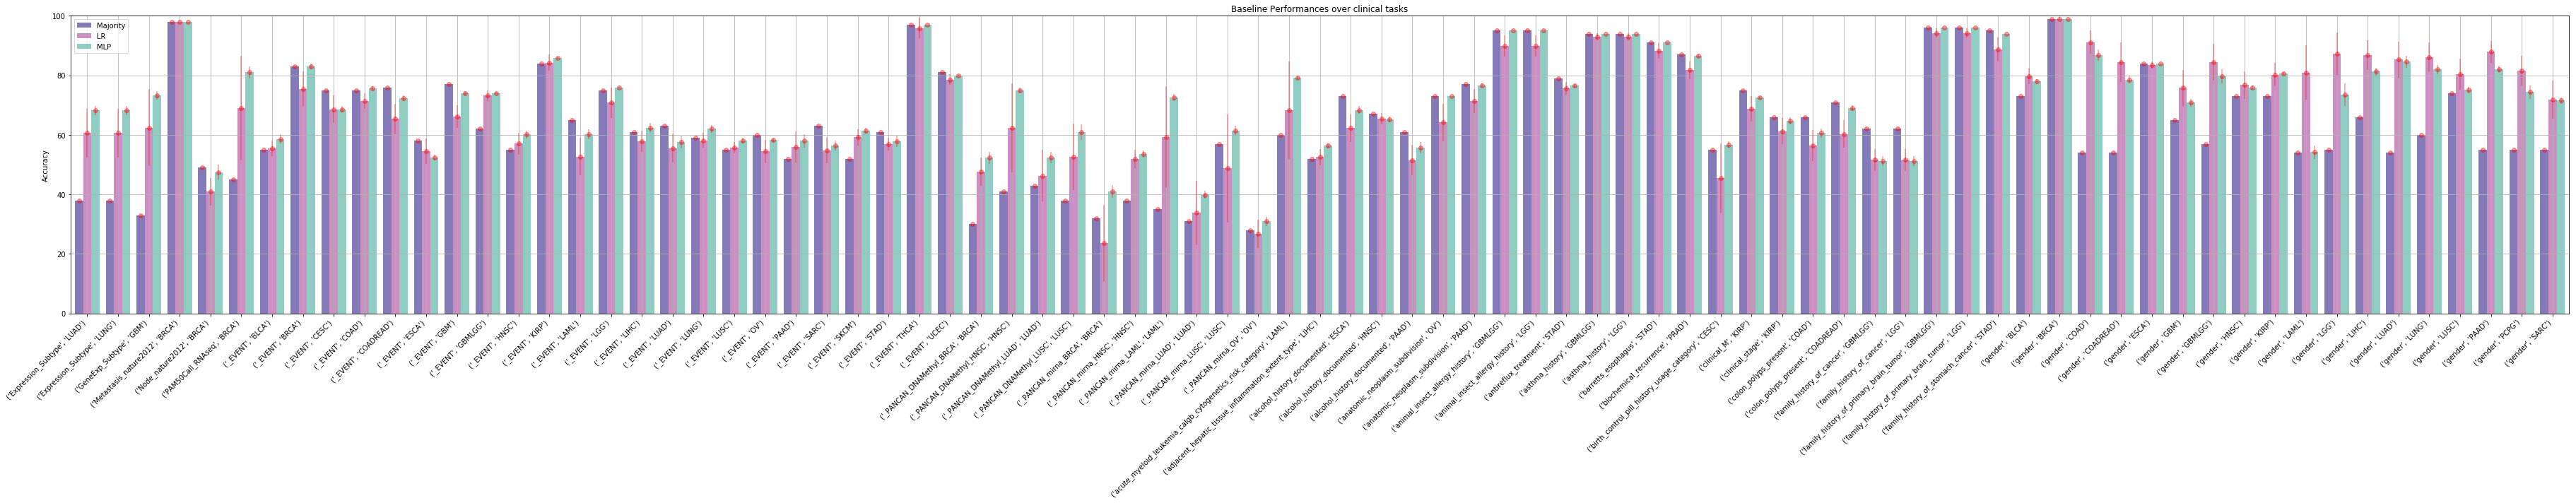

In [379]:
all_visualization(Maj_dict, LR_dict, MLP_dict)

In [380]:
print(MLP_dict)

{('Expression_Subtype', 'LUAD'): {'mean': 68.2, 'std': 1.5999999999999999}, ('Expression_Subtype', 'LUNG'): {'mean': 68.2, 'std': 1.5999999999999999}, ('GeneExp_Subtype', 'GBM'): {'mean': 73.3, 'std': 1.4177446878757824}, ('Metastasis_nature2012', 'BRCA'): {'mean': 98.0, 'std': 0.0}, ('Node_nature2012', 'BRCA'): {'mean': 47.5, 'std': 2.4596747752497685}, ('PAM50Call_RNAseq', 'BRCA'): {'mean': 81.0, 'std': 2.04939015319192}, ('_EVENT', 'BLCA'): {'mean': 58.6, 'std': 1.5620499351813317}, ('_EVENT', 'BRCA'): {'mean': 82.9, 'std': 0.9433981132056604}, ('_EVENT', 'CESC'): {'mean': 68.6, 'std': 1.1135528725660042}, ('_EVENT', 'COAD'): {'mean': 75.7, 'std': 0.6403124237432849}, ('_EVENT', 'COADREAD'): {'mean': 72.4, 'std': 0.9165151389911681}, ('_EVENT', 'ESCA'): {'mean': 52.4, 'std': 0.9165151389911679}, ('_EVENT', 'GBM'): {'mean': 73.9, 'std': 0.7000000000000001}, ('_EVENT', 'GBMLGG'): {'mean': 74.1, 'std': 0.30000000000000004}, ('_EVENT', 'HNSC'): {'mean': 60.1, 'std': 1.3000000000000012},

# Model Comparison

In [383]:
mean_mean = []
mean_std = []

Mlp_means, Mlp_std = [], []
LR_means, LR_std = [], []
Maj_means, Maj_std = [], []
tasks = Maj_dict.keys()

for task in tasks:
    Maj_means.append(Maj_dict[task]['mean'])
    Maj_std.append(Maj_dict[task]['std'])
    LR_means.append(LR_dict[task]['mean'])
    LR_std.append(LR_dict[task]['std'])
    Mlp_means.append(MLP_dict[task]['mean'])
    Mlp_std.append(MLP_dict[task]['std'])

mean_mean.append(np.mean(Maj_means))
mean_mean.append(np.mean(LR_means))
mean_mean.append(np.mean(Mlp_means))

mean_std.append(np.std(Maj_means))
mean_std.append(np.std(LR_means))
mean_std.append(np.std(Mlp_means))

print(mean_mean)
print(mean_std)

[66.18181818181819, 68.78512396694214, 71.19090909090909]
[16.879739922010373, 15.918857150475835, 14.624783674320149]


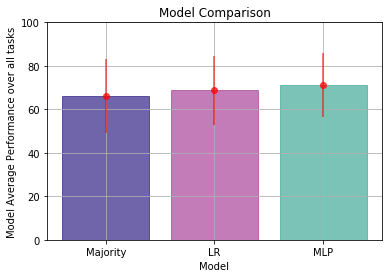

In [394]:
barlist=plt.bar([1,2,3], mean_mean, alpha=0.7)
barlist[0].set_color('#332288')
barlist[1].set_color('#AA4499')
barlist[2].set_color('#44AA99')
plt.xticks([1, 2, 3], ['Majority','LR','MLP'])
plt.title("Model Comparison")
plt.ylabel('Model Average Performance over all tasks')
plt.xlabel('Model')
plt.ylim(0,100)
plt.errorbar([1,2,3], mean_mean, mean_std, linestyle='None', marker='o', color='r', alpha=0.7)
plt.grid()
plt.show()